# Analiza i klasifikacija sepse

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import scipy.stats as stats
from scipy.stats import skew

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.metrics import f1_score, roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score

from joblib import dump, load
import pickle

from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.linear_model import SGDClassifier
from scipy.stats import chi2_contingency

In [24]:
sns.set()

In [25]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [29]:
train.rename(columns = {'Sepssis': 'Sepsis'}, inplace = True)

In [30]:
train.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepsis
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,Negative
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,Positive


`ID`: Unique number to represent patient ID

`PRG`: Plasma glucose

`PL`: Blood Work Result-1 (mu U/ml)

`PR`: Blood Pressure (mm Hg)

`SK`: Blood Work Result-2 (mm)

`TS`: Blood Work Result-3 (mu U/ml)

`M11`: Body mass index (weight in kg/(height in m)^2

`BD2`: Blood Work Result-4 (mu U/ml)

`Age`: patients age (years)

`Insurance`: If a patient holds a valid insurance card

`Sepsis`: Positive if a patient in ICU will develop a sepsis , and Negative otherwise

In [31]:
# Dimenzije skupova
print("Number of rows in the training dataset:", train.shape[0])
print("Number of columns in the training dataset:", train.shape[1])

Number of rows in the training dataset: 599
Number of columns in the training dataset: 11


In [32]:
print("Number of rows in the test dataset:", test.shape[0])
print("Number of columns in the test dataset:", test.shape[1])

Number of rows in the test dataset: 169
Number of columns in the test dataset: 10


## EDA

In [33]:
df = train.copy()

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         599 non-null    object 
 1   PRG        599 non-null    int64  
 2   PL         599 non-null    int64  
 3   PR         599 non-null    int64  
 4   SK         599 non-null    int64  
 5   TS         599 non-null    int64  
 6   M11        599 non-null    float64
 7   BD2        599 non-null    float64
 8   Age        599 non-null    int64  
 9   Insurance  599 non-null    int64  
 10  Sepsis     599 non-null    object 
dtypes: float64(2), int64(7), object(2)
memory usage: 51.6+ KB


In [35]:
df.isna().sum()

ID           0
PRG          0
PL           0
PR           0
SK           0
TS           0
M11          0
BD2          0
Age          0
Insurance    0
Sepsis       0
dtype: int64

### Numeričke varijable

In [36]:
df.describe()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
count,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000
mean,3.824708,120.153589,68.732888,20.562604,79.460768,31.920033,0.481187,33.290484,0.686144
std,3.362839,32.682364,19.335675,16.017622,116.576176,8.008227,0.337552,11.828446,0.464447
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,0.000000,0.000000,27.100000,0.248000,24.000000,0.000000
50%,3.000000,116.000000,70.000000,23.000000,36.000000,32.000000,0.383000,29.000000,1.000000
75%,6.000000,140.000000,80.000000,32.000000,123.500000,36.550000,0.647000,40.000000,1.000000
max,17.000000,198.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Univarijatna analiza

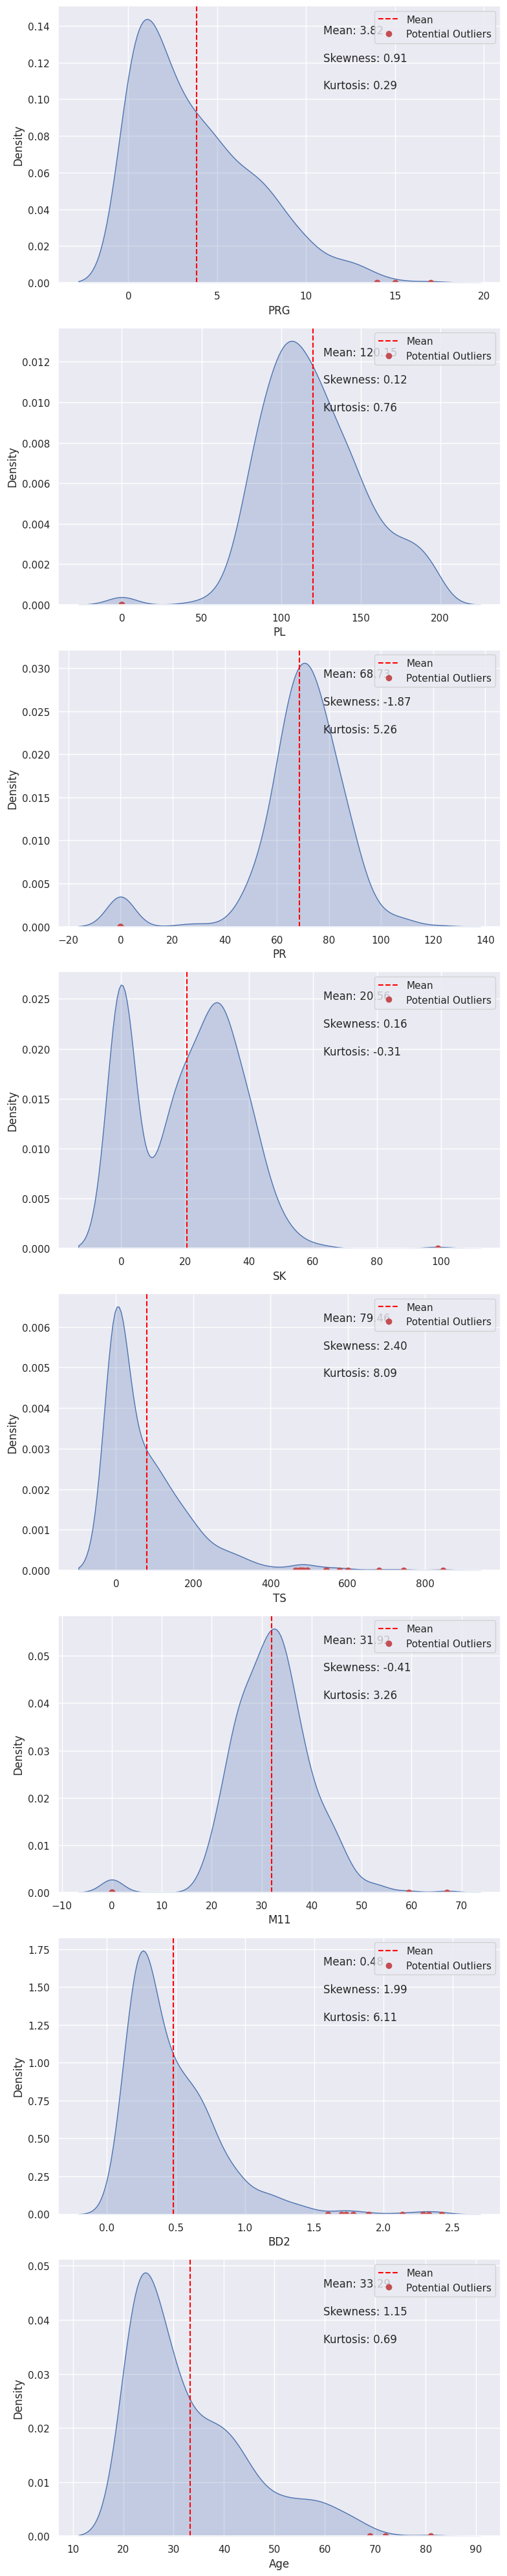

In [38]:
columns_to_plot = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age']

fig, axes = plt.subplots(nrows=len(columns_to_plot), figsize=(8, 40))
for i, col in enumerate(columns_to_plot):
    sns.kdeplot(data=df, x=col, ax=axes[i], fill=True)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')
    
    mean_val = df[col].mean()
    skewness_val = df[col].skew()
    kurtosis_val = df[col].kurtosis()
    
    axes[i].text(0.6, 0.9, f'Mean: {mean_val:.2f}', transform=axes[i].transAxes)
    axes[i].text(0.6, 0.8, f'Skewness: {skewness_val:.2f}', transform=axes[i].transAxes)
    axes[i].text(0.6, 0.7, f'Kurtosis: {kurtosis_val:.2f}', transform=axes[i].transAxes)
    
    axes[i].axvline(mean_val, color='red', linestyle='--', label='Mean')
    
    outliers = df[(df[col] > mean_val + 3 * df[col].std()) | (df[col] < mean_val - 3 * df[col].std())]
    axes[i].plot(outliers[col], [0] * len(outliers), 'ro', label='Potential Outliers')
    
    axes[i].legend()
    
plt.tight_layout()
plt.show()

#### Analiza stršila

Number of outliers in PRG: 4


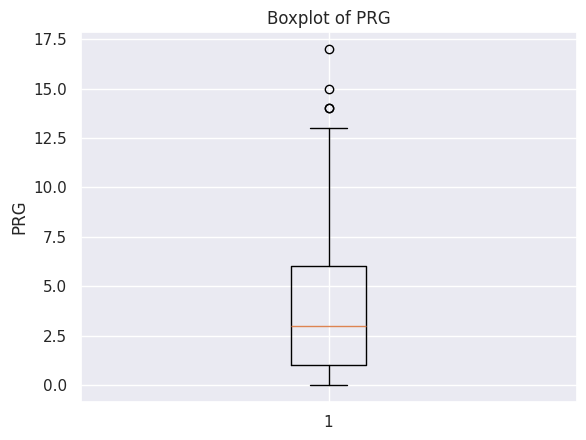

Number of outliers in PL: 0


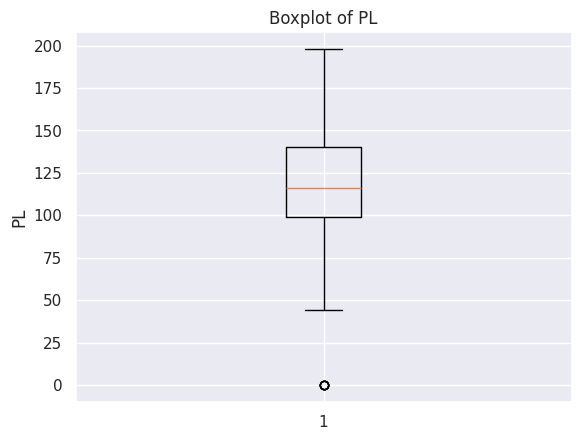

Number of outliers in PR: 6


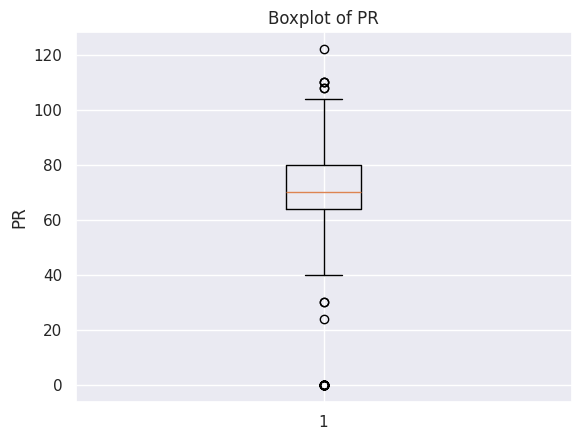

Number of outliers in SK: 1


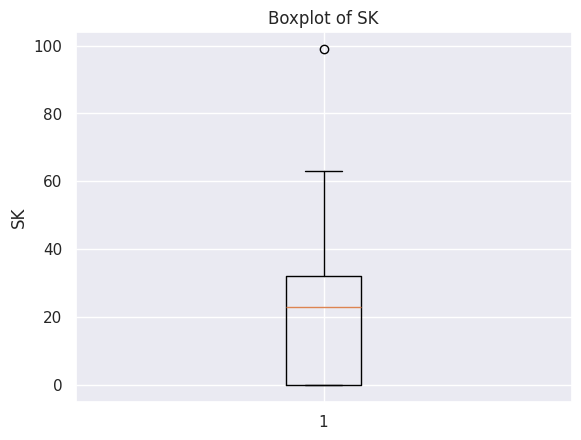

Number of outliers in TS: 28


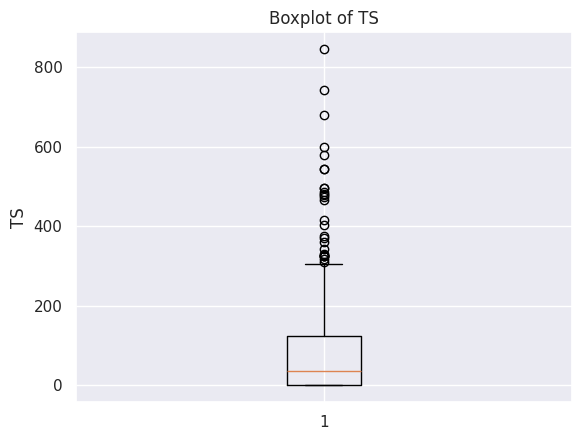

Number of outliers in M11: 7


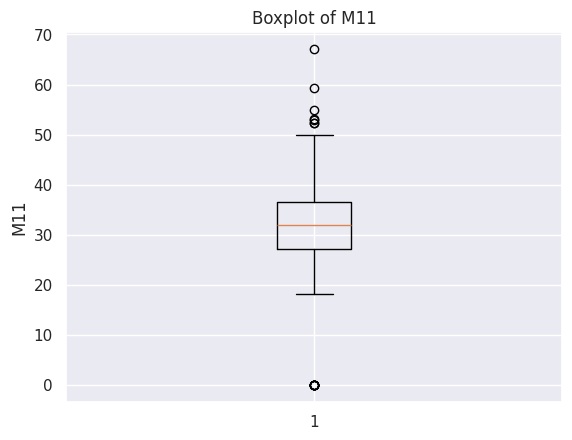

Number of outliers in BD2: 19


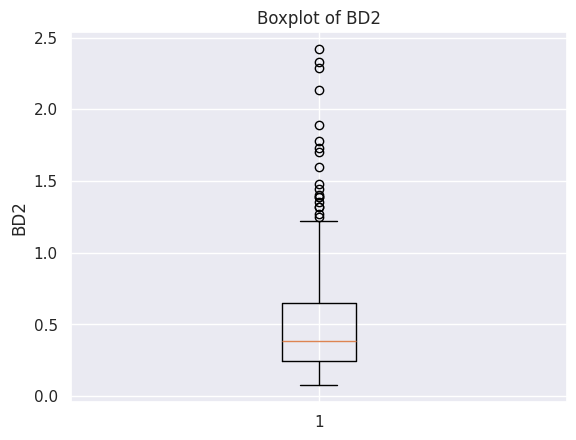

Number of outliers in Age: 12


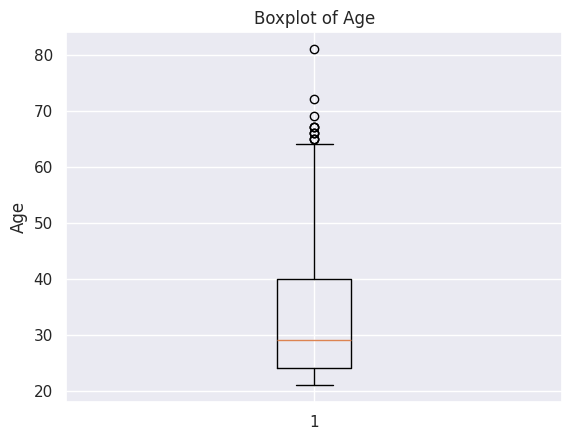

Number of outliers in Insurance: 0


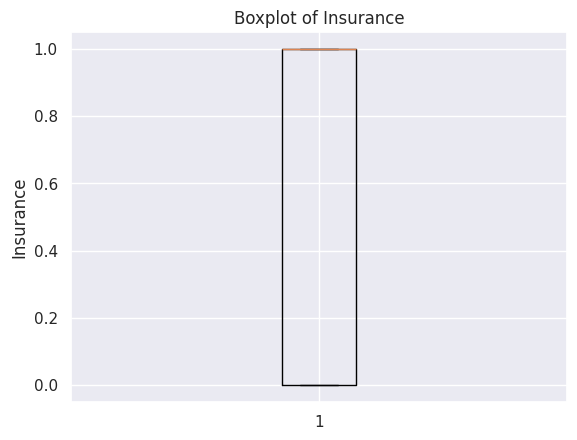

In [39]:
numerical_cols = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance']

for col in numerical_cols:
    plt.boxplot(df[col])
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)

    outliers = df[df[col] > df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25))]

    num_outliers = len(outliers)
    print(f"Number of outliers in {col}: {num_outliers}")

    plt.show()

### Bivarijatna analiza

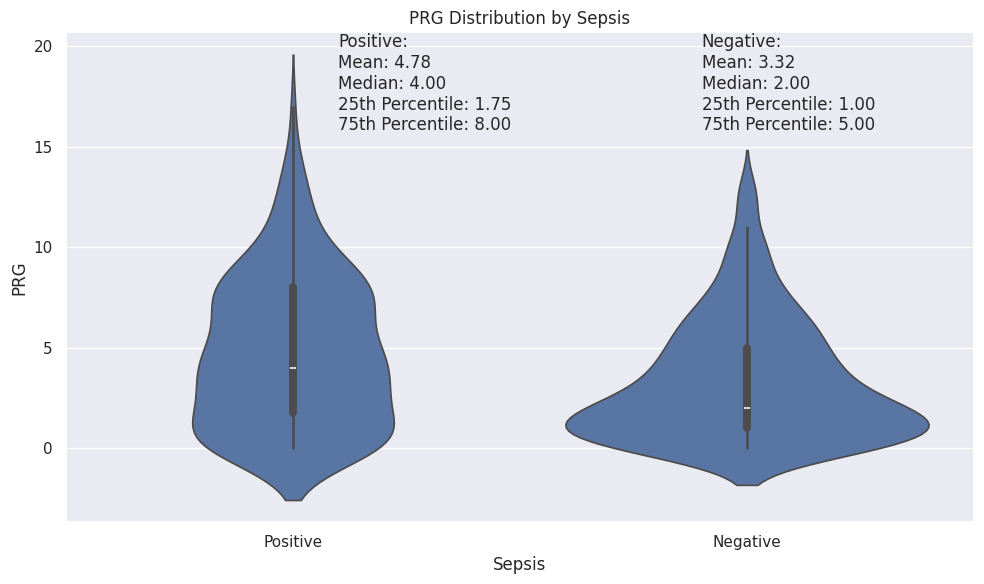

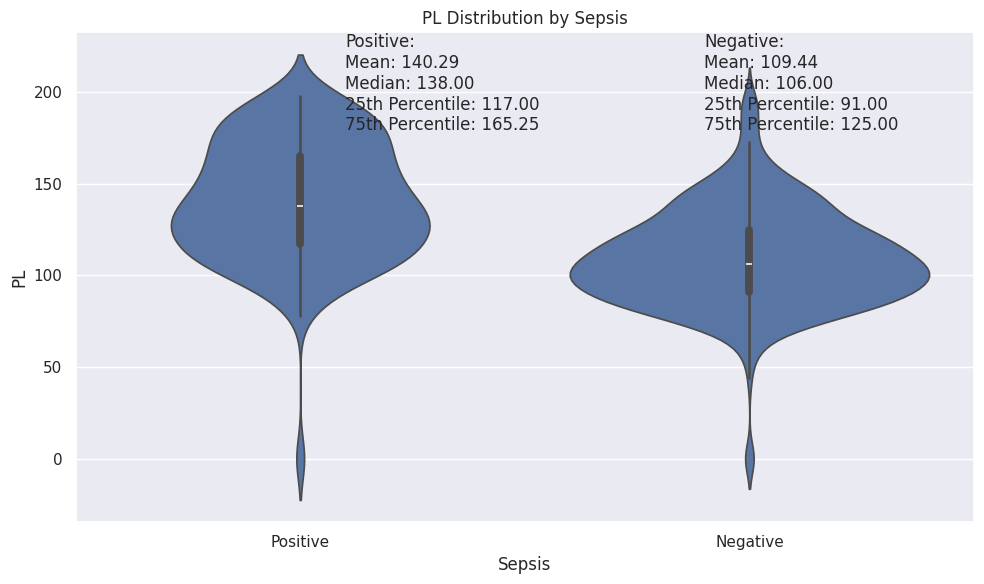

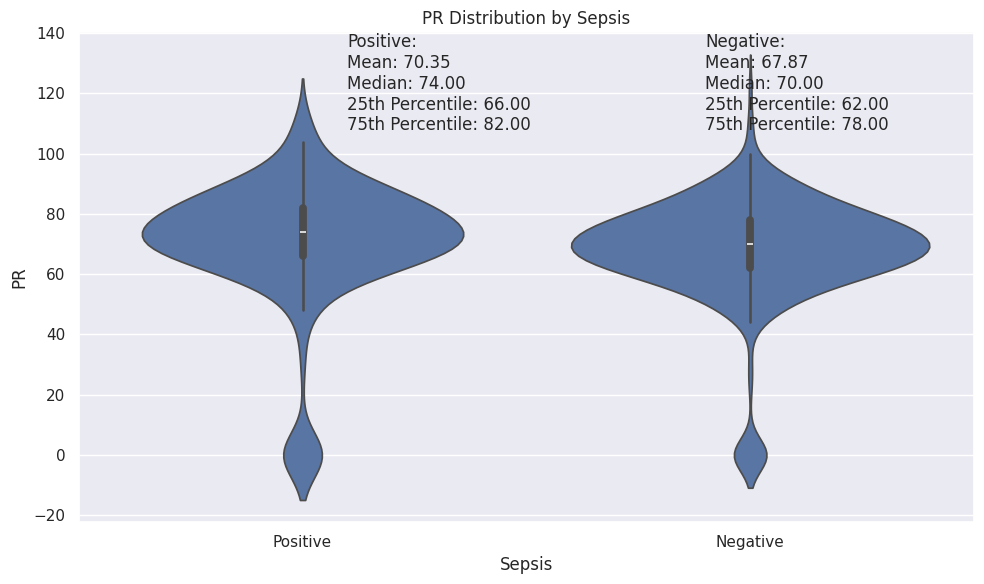

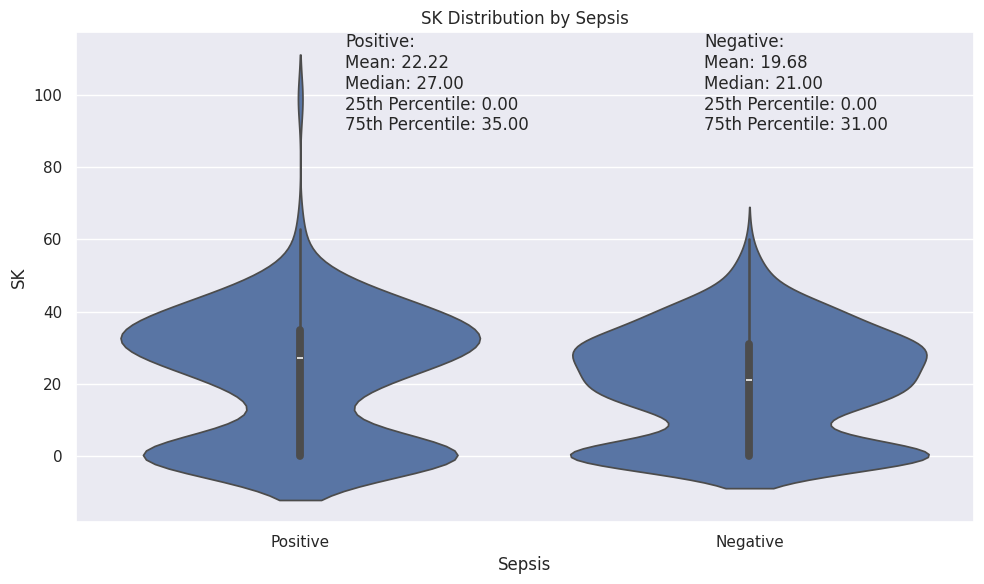

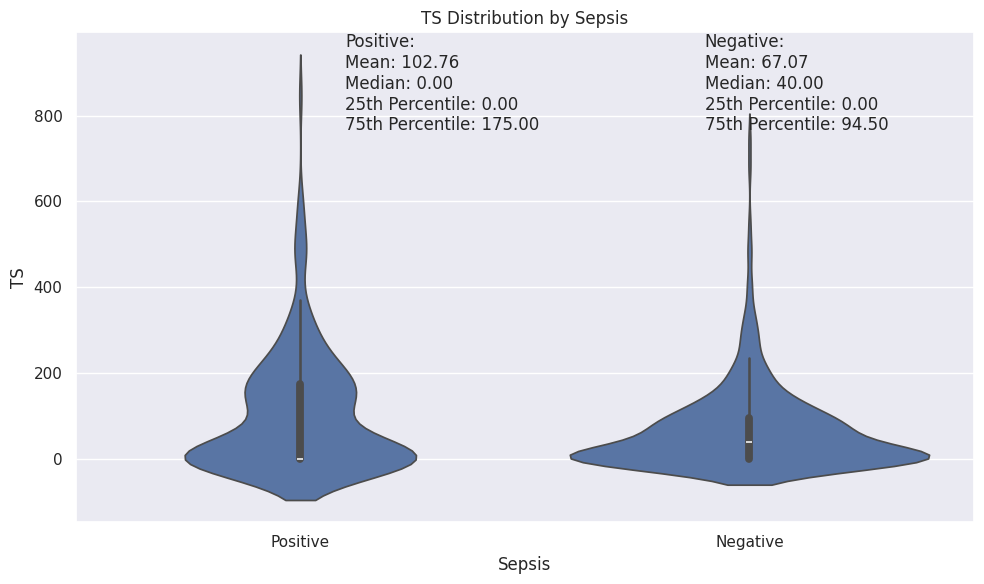

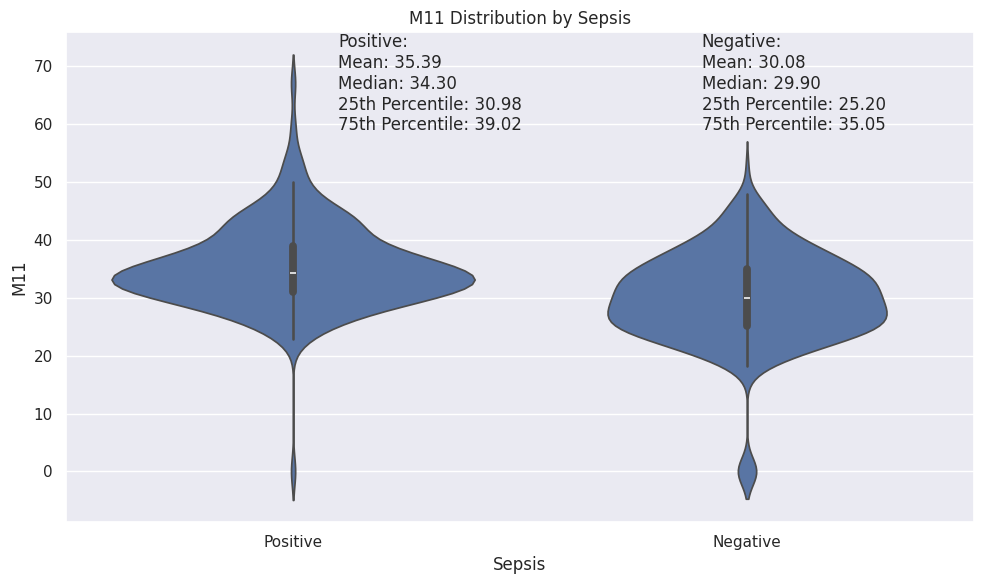

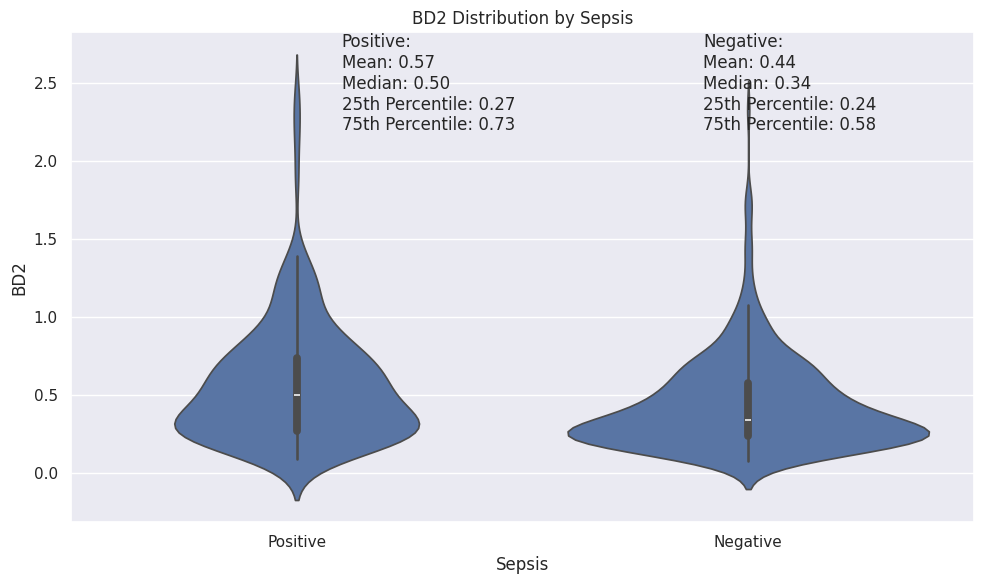

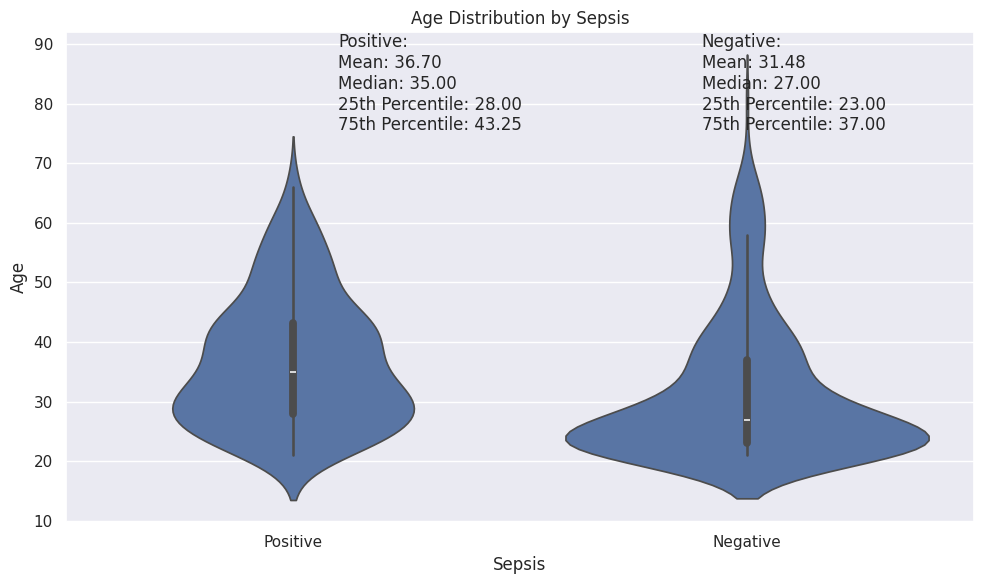

In [42]:
numerical_vars = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age']

for var in numerical_vars:
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=df, x='Sepsis', y=var)
    plt.xlabel('Sepsis')
    plt.ylabel(var)
    plt.title(f'{var} Distribution by Sepsis')
    
    positive_vals = df[df['Sepsis'] == 'Positive'][var]
    negative_vals = df[df['Sepsis'] == 'Negative'][var]
    stat_dict = {
        'Positive': {
            'Mean': np.mean(positive_vals),
            'Median': np.median(positive_vals),
            '25th Percentile': np.percentile(positive_vals, 25),
            '75th Percentile': np.percentile(positive_vals, 75)
        },
        'Negative': {
            'Mean': np.mean(negative_vals),
            'Median': np.median(negative_vals),
            '25th Percentile': np.percentile(negative_vals, 25),
            '75th Percentile': np.percentile(negative_vals, 75)
        }
    }
    
    plt.text(0.30, 0.8, f"Positive:\nMean: {stat_dict['Positive']['Mean']:.2f}\nMedian: {stat_dict['Positive']['Median']:.2f}\n25th Percentile: {stat_dict['Positive']['25th Percentile']:.2f}\n75th Percentile: {stat_dict['Positive']['75th Percentile']:.2f}", transform=plt.gca().transAxes)
    plt.text(0.70, 0.8, f"Negative:\nMean: {stat_dict['Negative']['Mean']:.2f}\nMedian: {stat_dict['Negative']['Median']:.2f}\n25th Percentile: {stat_dict['Negative']['25th Percentile']:.2f}\n75th Percentile: {stat_dict['Negative']['75th Percentile']:.2f}", transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

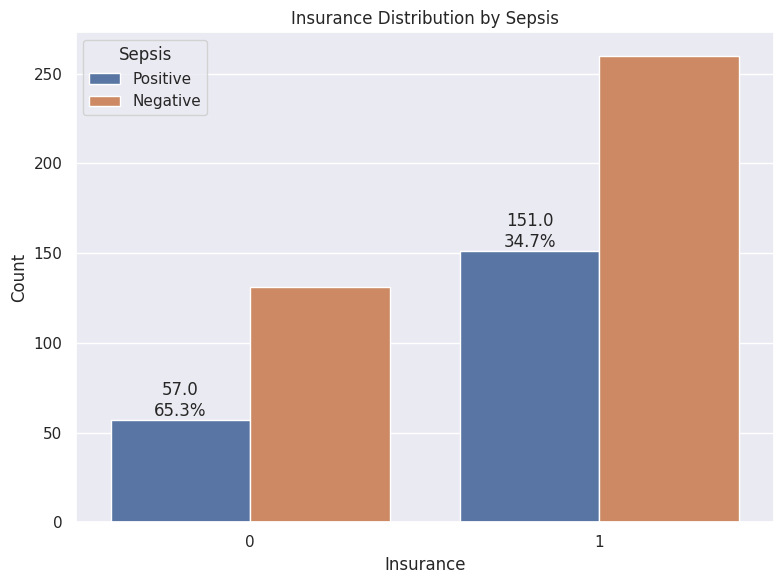

In [43]:
categorical_vars = ['Insurance']
for var in categorical_vars:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x=var, hue='Sepsis')
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.title(f'{var} Distribution by Sepsis')

    # Percentage distribution
    total = len(df['Sepsis'])
    percentages = df['Sepsis'].value_counts(normalize=True) * 100

    for p, percentage in zip(plt.gca().patches, percentages):
        count = p.get_height()
        percentage_label = f'{percentage:.1f}%'
        plt.gca().annotate(f'{count}\n{percentage_label}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

In [44]:
df['Sepsis_Encoded'] = df['Sepsis'].apply(lambda x: 1 if x == 'Positive' else 0)

numerical_vars = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance']
correlations = df[numerical_vars + ['Sepsis_Encoded']].corr()

for var in numerical_vars:
    correlation = correlations.loc[var, 'Sepsis_Encoded']
    print(f"Pearson correlation between 'Sepssis_Encoded' and '{var}': {correlation:.2f}")

Pearson correlation between 'Sepssis_Encoded' and 'PRG': 0.21
Pearson correlation between 'Sepssis_Encoded' and 'PL': 0.45
Pearson correlation between 'Sepssis_Encoded' and 'PR': 0.06
Pearson correlation between 'Sepssis_Encoded' and 'SK': 0.08
Pearson correlation between 'Sepssis_Encoded' and 'TS': 0.15
Pearson correlation between 'Sepssis_Encoded' and 'M11': 0.32
Pearson correlation between 'Sepssis_Encoded' and 'BD2': 0.18
Pearson correlation between 'Sepssis_Encoded' and 'Age': 0.21
Pearson correlation between 'Sepssis_Encoded' and 'Insurance': 0.06


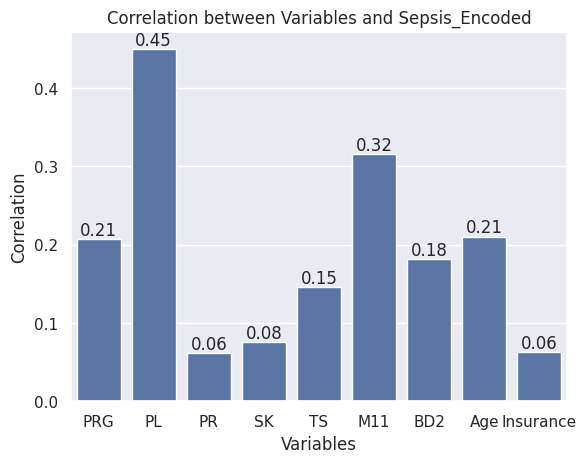

In [45]:
numerical_vars = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance']
correlations = df[numerical_vars + ['Sepsis_Encoded']].corr()

correlation_values = correlations.loc[numerical_vars, 'Sepsis_Encoded']

sns.barplot(x=numerical_vars, y=correlation_values)

for i, val in enumerate(correlation_values):
    plt.text(i, val, round(val, 2), ha='center', va='bottom')

plt.xlabel('Variables')
plt.ylabel('Correlation')
plt.title('Correlation between Variables and Sepsis_Encoded')

plt.show()

Analiza korelacije s `Sepsis_Encoded` otkriva:

- `PRG` i `Age` imaju slabe pozitivne korelacije (0.21), što ukazuje na blagi porast vjerojatnosti sepse s višim razinama plazma glukoze i starijom dobi.
- `PL` pokazuje umjerenu pozitivnu korelaciju (0.45), sugerirajući jaču vezu s vjerojatnošću sepse.
- `PR`, `SK` i `Insurance` pokazuju vrlo slabe pozitivne korelacije (0.06, 0.08, 0.06), što implicira zanemarive veze s vjerojatnošću sepse.
- `TS` i `BD2` također imaju slabe pozitivne korelacije (0.15, 0.18), sugerirajući ograničene asocijacije sa sepsom.
- `M11` (BMI) ima umjerenu pozitivnu korelaciju (0.32), ukazujući na izraženiju vezu s vjerojatnošću sepse.

Ukupno gledajući, `PL` i `BMI` imaju jače pozitivne korelacije s vjerojatnošću sepse, dok druge varijable pokazuju ograničene ili zanemarive veze.

/tmp/ipykernel_60852/1927235154.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df.groupby(age_ranges)


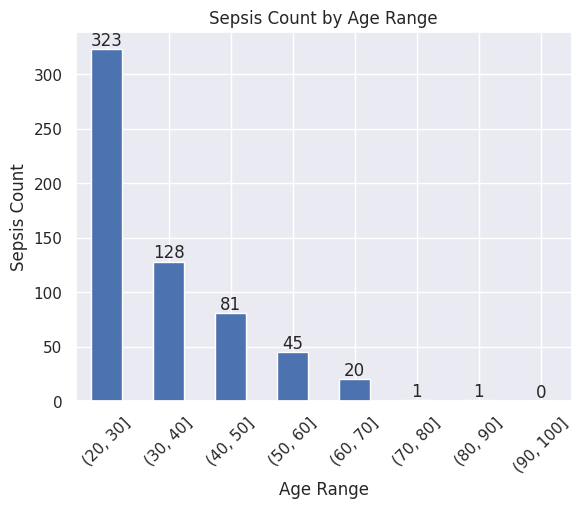

In [46]:
age_ranges = pd.cut(df['Age'], bins=[20, 30, 40, 50, 60, 70, 80, 90, 100])
grouped_data = df.groupby(age_ranges)

count_sepsis_by_age = grouped_data['Sepsis'].count()

ax = count_sepsis_by_age.plot(kind='bar', xlabel='Age Range', ylabel='Sepsis Count', title='Sepsis Count by Age Range')
plt.xticks(rotation=45)

for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

plt.show()

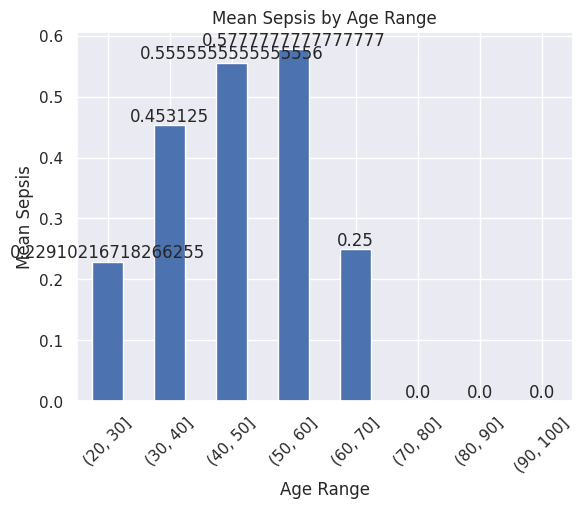

In [47]:
mean_sepsis_by_age = grouped_data['Sepsis_Encoded'].mean()

ax = mean_sepsis_by_age.plot(kind='bar', xlabel='Age Range', ylabel='Mean Sepsis', title='Mean Sepsis by Age Range')
plt.xticks(rotation=45)

for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

plt.show()

Podaci pokazuju da dobna skupina (20, 30] ima najveći broj slučajeva sepse sa 323 slučaja, ali njezina prosječna stopa sepse je niža, na 0.23, u usporedbi s drugim dobnim skupinama. To sugerira da, unatoč visokom broju slučajeva, prevalencija sepse u ovoj demografiji je niža u odnosu na veličinu populacije. Veći brojevi populacije u dobnom rasponu (20, 30] povećavaju broj slučajeva, ali ne ukazuju nužno na veći rizik od sepse unutar te skupine. Suprotno tome, starije dobne skupine, unatoč manjem broju slučajeva, mogu imati veći udio slučajeva sepse u odnosu na njihovu manju veličinu populacije.

### Multivarijatna analiza

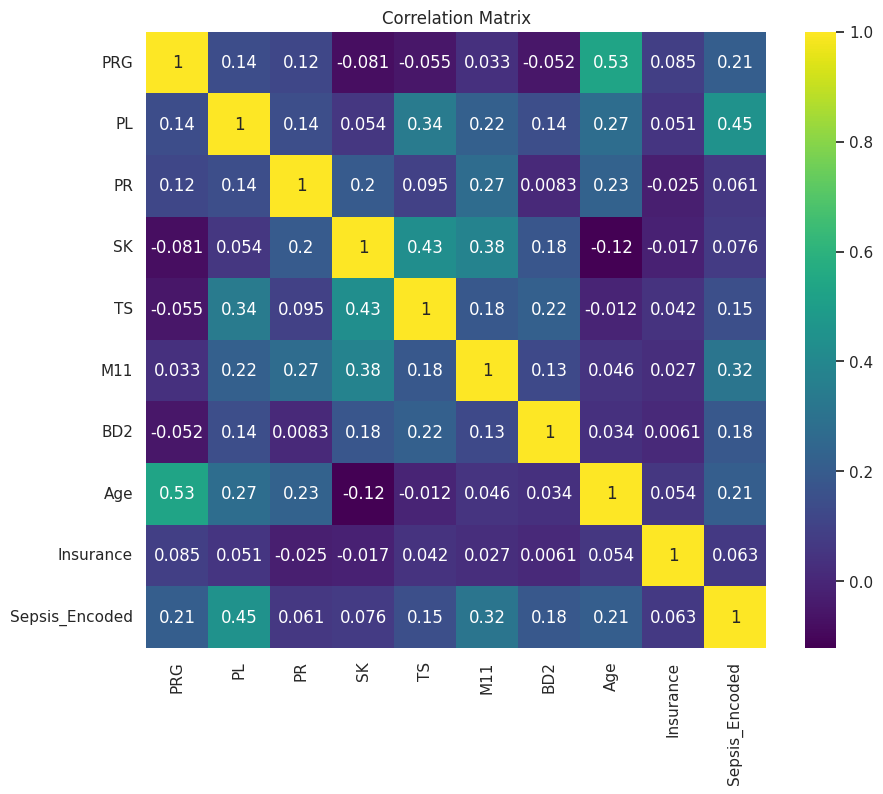

In [48]:
correlations = df[numerical_vars + ['Sepsis_Encoded']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='viridis')
plt.title('Correlation Matrix')
plt.show()

Korelacijska matrica prikazuje kako su međusobno povezane numeričke varijable u skupu podataka. Evo nekoliko ključnih uvida:

- Većina varijabli pokazuje nisku do umjerenu međusobnu korelaciju, što ukazuje na to da ne postoji jaka linearna zavisnost između njih.
- Postoje neke varijable s umjerenim korelacijama, ali nijedna od njih ne pokazuje izrazito visoku korelaciju koja bi ukazivala na potencijalnu redundantnost ili vrlo snažnu povezanost koja bi mogla biti ključna za predviđanja ili dublje analize.
- `M11` (BMI) pokazuje neku mjeru korelacije s `PL` (razina plazma glukoze), što bi moglo sugerirati da osobe s višim `BMI`-om imaju tendenciju imati više razine glukoze, što je usklađeno s općeprihvaćenim medicinskim znanjem.
- Ostale varijable, kao što su `Age` i `PRG`, također pokazuju blagu korelaciju, što može ukazivati na to da s dobi raste broj trudnoća, što je očekivano.

Nema očitih korelacija koje bi ukazivale na direktan i jak utjecaj jedne varijable na drugu, što znači da za dublje uvide možda trebamo istražiti ne-linearne veze ili uključiti dodatne analitičke metode.

Da bismo analizirali povezanost između statusa sepse (`Sepsis`) i ostalih varijabli, možemo razmotriti korištenje grupnih statistika (npr. prosječne vrijednosti numeričkih varijabli po statusu sepse) i testova za kategoričke varijable (npr., chi-kvadrat test za varijablu `Insurance`). Ovo će nam pomoći da vidimo postoji li značajna razlika u numeričkim varijablama ovisno o statusu sepsisa i koliko je status osiguranja povezan sa statusom sepsisa.

Za analizu veze između statusa sepse (`Sepsis`) i numeričkih varijabli, koristit ćemo grupne statistike da bismo vidjeli kako se prosječne vrijednosti numeričkih varijabli razlikuju između pacijenata s pozitivnim i negativnim statusom sepse. Ovo će nam dati uvid u to koje bi varijable mogle biti važne u kontekstu sepse.

Nakon toga, istražit ćemo povezanost između statusa sepse i varijable `Insurance` korištenjem chi-kvadrat testa, koji je koristan za testiranje hipoteza o neovisnosti između kategoričkih varijabli.

**Grupne statistike numeričkih varijabli po statusu sepse**

Kada usporedimo prosječne vrijednosti numeričkih varijabli između pacijenata s pozitivnim i negativnim statusom sepse, uočavamo nekoliko ključnih razlika:

- `PL`: Pacijenti s pozitivnim statusom sepse imaju znatno višu prosječnu razinu glukoze u usporedbi s onima s negativnim statusom. Ovo ukazuje na moguću povezanost između viših razina glukoze i sepse.
- `M11` i `BD2`: Također su viši kod pacijenata s pozitivnim statusom sepse, što sugerira da postoji veza između sepse i faktora kao što su BMI i genetska predispozicija za dijabetes.
- `Age` i `TS`: Pacijenti s pozitivnim statusom sepse su u prosjeku stariji i imaju više vrijednosti inzulina. To može ukazivati na to da stariji pacijenti s većim razinama inzulina imaju veći rizik od sepse.
- `Insurance`: Postoji blaga razlika u udjelu osiguranih pacijenata između dviju grupa, s višim udjelom osiguranih među pacijentima s pozitivnim statusom sepse.

Da bismo dalje istražili povezanost između statusa sepse i varijable `Insurance`, provest ćemo chi-kvadrat test.

In [50]:
grouped_stats = df.groupby('Sepsis')[numerical_vars].mean()

grouped_stats

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
Sepsis,,,,,,,,,
Negative,3.317136,109.442455,67.872123,19.680307,67.066496,30.076471,0.436524,31.478261,0.664962
Positive,4.778846,140.288462,70.350962,22.221154,102.759615,35.385577,0.565144,36.697115,0.725962


In [51]:
contingency_table = pd.crosstab(df['Insurance'], df['Sepsis'])

chi2, p_value, dof, expected = chi2_contingency(contingency_table)

chi2, p_value, dof, expected

(2.0712782081677066,
 0.1500956791860619,
 1,
 array([[122.71786311,  65.28213689],
        [268.28213689, 142.71786311]]))

**Rezultati chi-kvadrat testa**

Rezultati Chi-kvadrat testa za varijablu `Insurance` i status `Sepsis` su sljedeći:

- **Chi-kvadrat statistika:** 2.0713
- **p-vrijednost:** 0.1501
- **Stupnjevi slobode (dof):** 1

Chi-kvadrat statistika testira hipotezu da nema povezanosti (neovisnosti) između statusa osiguranja i sepse. S obzirom na p-vrijednost od 0.1501, koja je veća od uobičajenog praga značajnosti od 0.05, **ne odbacujemo nultu hipotezu neovisnosti**. To znači da na temelju dostupnih podataka ne postoji statistički značajna povezanost između toga jesu li pacijenti osigurani i njihovog statusa sepsisa.

Kontigencijska tablica i očekivane vrijednosti pokazuju kako se stvarne i očekivane frekvencije uspoređuju za dvije varijable. Distribucija frekvencija je relativno blizu onome što bismo očekivali ako nema povezanosti, što podupire rezultate testa.

Ova analiza pomaže nam da shvatimo da, iako postoje neke razlike u prosječnim vrijednostima numeričkih varijabli između pacijenata s pozitivnim i negativnim statusom sepse, status osiguranja sam po sebi ne pokazuje statistički značajnu povezanost s tim statusom.

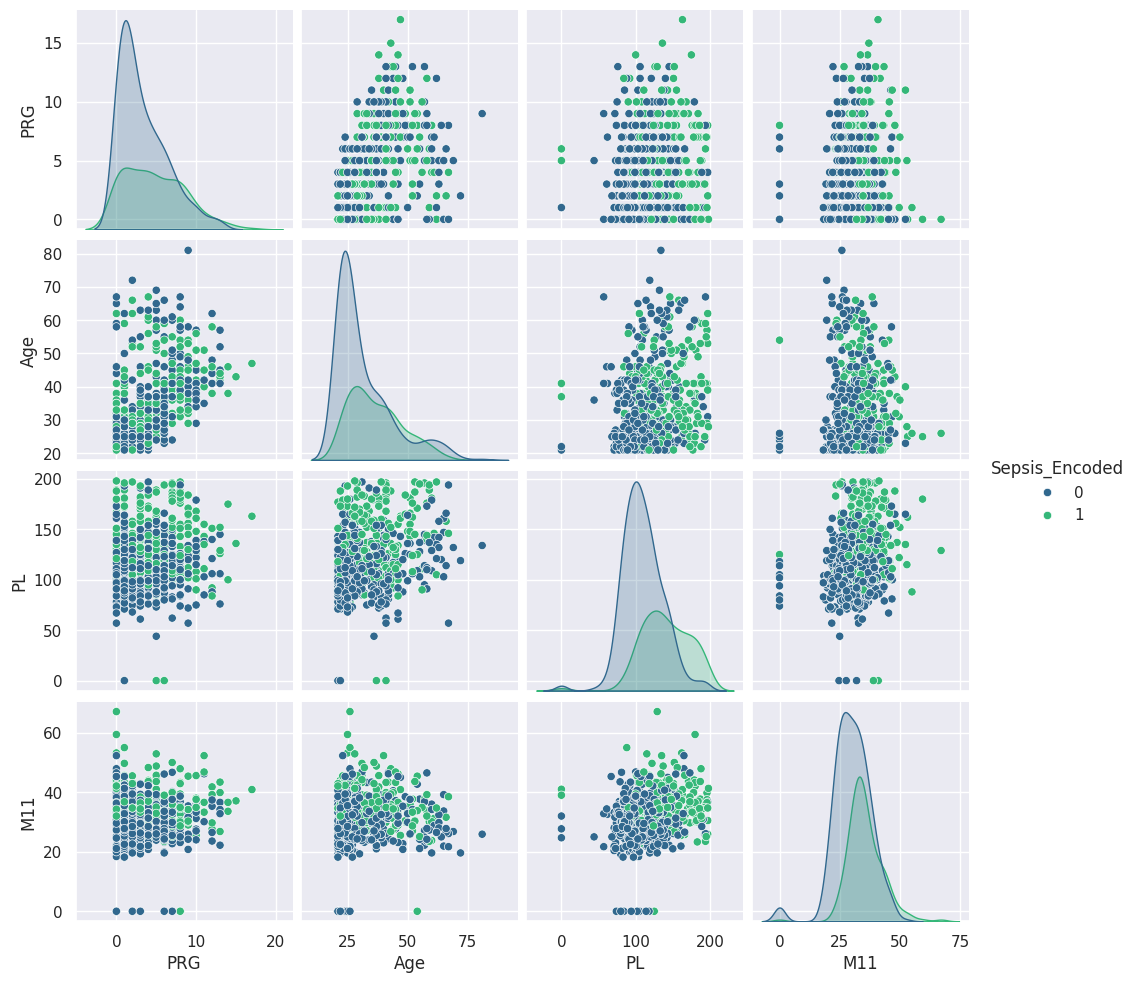

In [52]:
selected_variables = ['PRG', 'Age', 'PL', 'M11', 'Sepsis_Encoded']

sns.pairplot(df[selected_variables], hue='Sepsis_Encoded', diag_kind='kde', palette='viridis')
plt.show()

### Testiranje hipoteza

#### Hipoteza 1: Veće razine plazma glukoze (PRG) su povezane s povećanim rizikom od razvoja sepse
- **Nulta Hipoteza (H<sub>0</sub>):** Ne postoji povezanost između većih razina plazma glukoze (PRG) i rizika od razvoja sepse
- **Alternativna Hipoteza (H<sub>A</sub>):** Veće razine plazma glukoze (PRG) su povezane s povećanim rizikom od razvoja sepse
- **Obrazloženje:** Povećane razine glukoze su povezane s oštećenom funkcijom imunološkog sustava i povećanom osjetljivošću na infekcije, uključujući sepsu

In [53]:
grouped_data = df.groupby('Sepsis')

positive_group = grouped_data.get_group('Positive')
negative_group = grouped_data.get_group('Negative')

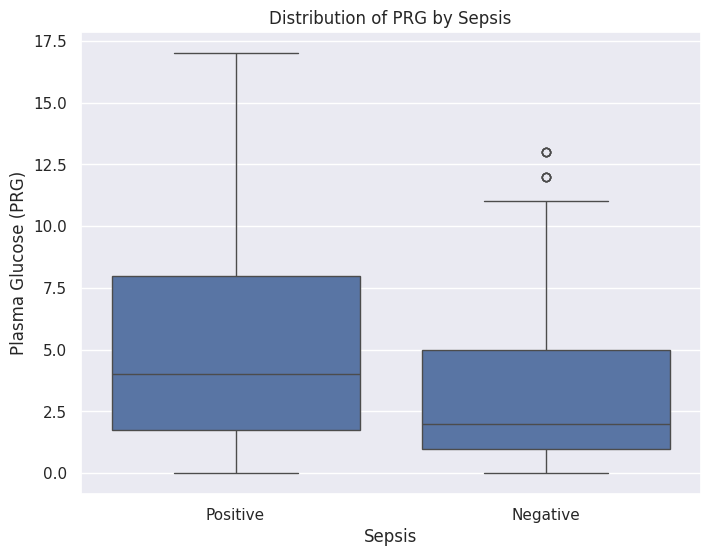

Positive Group:
Mean PRG: 4.778846153846154
Median PRG: 4.0
Standard Deviation: 3.75572151161869

Negative Group:
Mean PRG: 3.317135549872123
Median PRG: 2.0
Standard Deviation: 3.018182162951502

t-statistic: 5.172721512358376
p-value: 3.154172341568826e-07


In [55]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Sepsis', y='PRG')
plt.xlabel('Sepsis')
plt.ylabel('Plasma Glucose (PRG)')
plt.title('Distribution of PRG by Sepsis')
plt.show()

positive_prg = positive_group['PRG']
negative_prg = negative_group['PRG']

positive_mean = positive_prg.mean()
positive_median = positive_prg.median()
positive_std = positive_prg.std()

negative_mean = negative_prg.mean()
negative_median = negative_prg.median()
negative_std = negative_prg.std()

print('Positive Group:')
print('Mean PRG:', positive_mean)
print('Median PRG:', positive_median)
print('Standard Deviation:', positive_std)
print()

print('Negative Group:')
print('Mean PRG:', negative_mean)
print('Median PRG:', negative_median)
print('Standard Deviation:', negative_std)
print()

t_statistic, p_value = stats.ttest_ind(positive_prg, negative_prg)
print('t-statistic:', t_statistic)
print('p-value:', p_value)

#### Analiza
Grupirani podaci na temelju statusa sepse pokazuju:

- **Pozitivna Grupa:**
  - Prosjek PRG: 4.78
  - Medijan PRG: 4.0
  - Standardna devijacija: 3.76

- **Negativna Grupa:**
  - Prosjek PRG: 3.32
  - Medijan PRG: 2.0
  - Standardna devijacija: 3.02

Boxplot pokazuje distribuciju PRG po statusu sepse, sugerirajući veće vrijednosti PRG u pozitivnoj grupi.

#### Statistička Analiza
- **t-statistika:** 5.17
- **p-vrijednost:** 3.15e-07

Velika t-statistika i vrlo mala p-vrijednost ukazuju na statistički značajnu razliku između prosječnih vrijednosti PRG u pozitivnoj i negativnoj grupi. Ovo pruža snažne dokaze protiv nulte hipoteze, sugerirajući da razlika u prosječnim razinama plazma glukoze između grupa jest statistički značajna.

#### Interpretacija
Na temelju analize, postoji značajna povezanost između viših razina plazma glukoze i rizika od razvoja sepse. Pacijenti sa sepsom, u prosjeku, imaju veće razine plazma glukoze u usporedbi s onima bez sepse. Medijan PRG u pozitivnoj grupi je 4.0, dok je u negativnoj grupi 2.0, što dodatno podržava zapažanje da je centralna tendencija razina plazma glukoze viša u pozitivnoj grupi. Visoke standardne devijacije u obje grupe ukazuju na značajnu varijabilnost razina plazma glukoze unutar svake grupe.

Ukratko, postoji značajna veza između viših razina plazma glukoze i povećanog rizika od sepse, što podržava alternativnu hipotezu.

#### Hipoteza 2: Stariji pacijenti su skloniji razvoju sepse u usporedbi s mlađim pacijentima

- **Nulta Hipoteza (H<sub>0</sub>):** Ne postoji razlika u vjerojatnosti razvoja sepse između starijih i mlađih pacijenata
- **Alternativna Hipoteza (H<sub>A</sub>):** Stariji pacijenti su skloniji razvoju sepse u usporedbi s mlađim pacijentima
- **Obrazloženje:** Napredna dob je poznati faktor rizika za sepsu, jer s godinama imunološki sustav slabi i može biti manje sposoban za učinkovit odgovor na infekcije

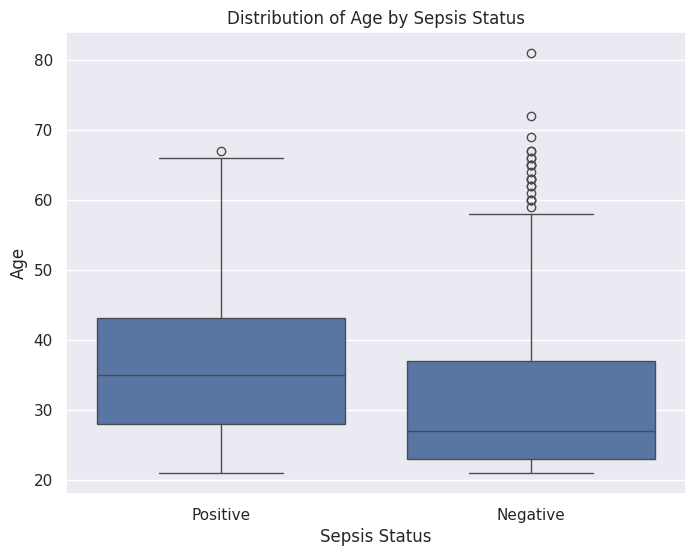

Positive Group:
Mean Age: 36.69711538461539
Median Age: 35.0
Standard Deviation: 10.904929140599736

Negative Group:
Mean Age: 31.47826086956522
Median Age: 27.0
Standard Deviation: 11.913530900036797

t-statistic: 5.254202967191448
p-value: 2.0718778891881855e-07


In [56]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Sepsis', y='Age')
plt.xlabel('Sepsis Status')
plt.ylabel('Age')
plt.title('Distribution of Age by Sepsis Status')
plt.show()

positive_age = positive_group['Age']
negative_age = negative_group['Age']

positive_mean = positive_age.mean()
positive_median = positive_age.median()
positive_std = positive_age.std()

negative_mean = negative_age.mean()
negative_median = negative_age.median()
negative_std = negative_age.std()

print('Positive Group:')
print('Mean Age:', positive_mean)
print('Median Age:', positive_median)
print('Standard Deviation:', positive_std)
print()

print('Negative Group:')
print('Mean Age:', negative_mean)
print('Median Age:', negative_median)
print('Standard Deviation:', negative_std)
print()

t_statistic, p_value = stats.ttest_ind(positive_age, negative_age)
print('t-statistic:', t_statistic)
print('p-value:', p_value)

#### Analiza

Grupirani podaci na temelju statusa sepse pokazuju:

- **Pozitivna Grupa:**
  - Prosjek dobi: 36.70 godina
  - Medijan dobi: 35.0 godina
  - Standardna devijacija: 10.90 godina

- **Negativna Grupa:**
  - Prosjek dobi: 31.48 godina
  - Medijan dobi: 27.0 godina
  - Standardna devijacija: 11.91 godina

Boxplot pokazuje distribuciju dobi po statusu sepse, sugerirajući veće vrijednosti dobi u pozitivnoj grupi.

#### Statistička Analiza

- **t-statistika:** 5.25
- **p-vrijednost:** 2.07e-07

Velika t-statistika i vrlo mala p-vrijednost ukazuju na statistički značajnu razliku između prosječnih vrijednosti dobi u pozitivnoj i negativnoj grupi. Ovo pruža snažne dokaze protiv nulte hipoteze, sugerirajući da razlika u prosječnoj dobi između grupa jest statistički značajna.

#### Interpretacija

Na temelju analize, postoji značajna povezanost između više dobi i rizika od razvoja sepse. Pacijenti sa sepsom, u prosjeku, su stariji u usporedbi s onima bez sepse. Ovo dodatno podržava zapažanje da je veća dob povezana s većim rizikom od sepse. Manja standardna devijacija u pozitivnoj grupi ukazuje na manju varijabilnost dobi među pacijentima s sepsom.

Ukratko, postoji značajna veza između više dobi i povećanog rizika od sepse, što podržava alternativnu hipotezu. Stoga možemo odbaciti nultu hipotezu.

#### Hipoteza 3: Neobični rezultati krvnih pretraga, kao što su visoke vrijednosti PL, SK i BD2, ukazuju na veću vjerojatnost sepse.

- **Nulta Hipoteza (H0):** Ne postoji povezanost između neobičnih rezultata krvnih pretraga, kao što su visoke vrijednosti PL, SK i BD2, i vjerojatnosti sepse.
- **Alternativna Hipoteza (HA):** Neobični rezultati krvnih pretraga, kao što su visoke vrijednosti PL, SK i BD2, ukazuju na veću vjerojatnost sepse.
- **Obrazloženje:** Neobični rezultati krvnih pretraga mogu ukazivati na trenutnu infekciju, koja je ključni faktor u razvoju sepse.

## Priprema podataka

### Balansiranost skupa podataka

/tmp/ipykernel_60852/1545950933.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Sepsis', palette=palette, edgecolor='black', ax=axes[1])


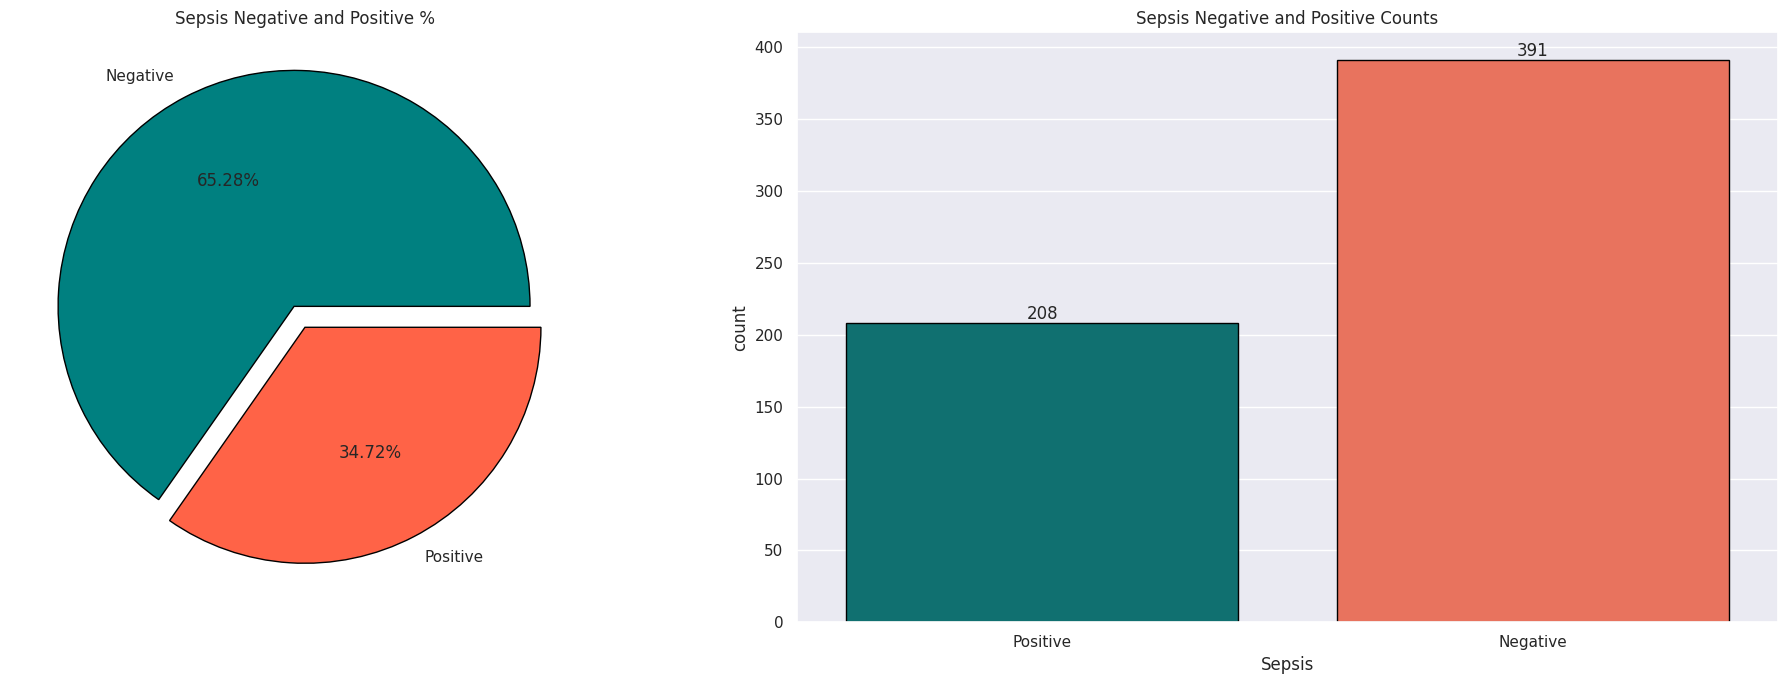

In [59]:
palette = ['#008080', '#FF6347']

# Postotci
sepsis_counts = df['Sepsis'].value_counts(normalize=True) * 100

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

axes[0].pie(sepsis_counts, labels=sepsis_counts.index, autopct='%1.2f%%', explode=(0.1, 0),
            colors=palette, wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True})
axes[0].set_title('Sepsis Negative and Positive %')

sns.countplot(data=df, x='Sepsis', palette=palette, edgecolor='black', ax=axes[1])
axes[1].set_title('Sepsis Negative and Positive Counts')

for container in axes[1].containers:
    axes[1].bar_label(container)

plt.tight_layout()
plt.show()

Iz ovih vizualizacija možemo zaključiti da dataset možda nije potpuno balansiran u pogledu statusa sepse. Vidljiva je razlika u broju pacijenata s pozitivnim i negativnim statusom sepse, što može utjecati na analizu i modeliranje podataka.

In [60]:
print(f'Number of duplicate rows in the training set: {df[df.duplicated()].shape[0]}')
print(f'Number of duplicate rows in the test set: {test[test.duplicated()].shape[0]}')

Number of duplicate rows in the training set: 0
Number of duplicate rows in the test set: 0


### Enkodiranje ciljne varijable

In [61]:
def encode_target_variable(data, target_variable):
    label_encoder = LabelEncoder()
    encoded_target = label_encoder.fit_transform(data[target_variable])
    target_encoded = pd.DataFrame(encoded_target, columns=[target_variable])

    data_encoded = pd.concat([data.iloc[:, :-1], target_encoded], axis=1)
    data_encoded.drop('ID', axis=1, inplace=True)

    return data_encoded

In [63]:
train_encoded = encode_target_variable(train, 'Sepsis')
train_encoded.head()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepsis
0,6,148,72,35,0,33.6,0.627,50,0,1
1,1,85,66,29,0,26.6,0.351,31,0,0
2,8,183,64,0,0,23.3,0.672,32,1,1
3,1,89,66,23,94,28.1,0.167,21,1,0
4,0,137,40,35,168,43.1,2.288,33,1,1


In [64]:
test.drop('ID',axis = 1,inplace = True)

### Podjela skupa (*train* i *val* skupovi)

In [65]:
def split_data(X, y, test_size, random_state=42, stratify=None):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42, stratify=stratify)

    return X_train, X_val, y_train, y_val

X_train, X_val, y_train, y_val = split_data(train_encoded.iloc[:, :-1], train_encoded.iloc[:, -1:], test_size=0.2, random_state=42, stratify=train_encoded.iloc[:, -1:])
y_train = y_train.values.ravel() if hasattr(y_train, 'values') else y_train.ravel()
y_val = y_val.values.ravel() if hasattr(y_val, 'values') else y_val.ravel()

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (479, 9)
y_train shape: (479,)
X_val shape: (120, 9)
y_val shape: (120,)


### Popunjavanje (imputing) nedostajućih vrijednosti

In [66]:
numerical_imputer = SimpleImputer(strategy = "mean")

numerical_imputer.fit(X_train)

X_train_imputed = numerical_imputer.transform(X_train)
X_val_imputed = numerical_imputer.transform(X_val)
X_test_imputed = numerical_imputer.transform(test)

### Skaliranje

In [67]:
scaler = StandardScaler()
scaler.fit(X_train_imputed)

columns = ['PRG','PL','PR','SK','TS','M11','BD2','Age','Insurance']

def scale_data(data, scaler, columns):
    scaled_data = scaler.transform(data)
    scaled_df = pd.DataFrame(scaled_data, columns=columns)
    return scaled_df

In [68]:
X_train_df = scale_data(X_train_imputed, scaler, columns)
X_val_df = scale_data(X_val_imputed, scaler, columns)
X_test = scale_data(X_test_imputed, scaler, columns)

## Modeliranje

In [69]:
def fit_and_evaluate_model(X_train, y_train, X_val, y_val, model):

    y_train = y_train.values.ravel() if hasattr(y_train, 'values') else y_train.ravel()
    y_val = y_val.values.ravel() if hasattr(y_val, 'values') else y_val.ravel()
    
    model.fit(X_train, y_train)
    
    preds = model.predict(X_val)

    f1_score_ = f1_score(y_val, preds)
    fpr, tpr, thresholds = roc_curve(y_val, preds)
    auc_score = roc_auc_score(y_val, preds)

    return model, preds, f1_score_, fpr, tpr, thresholds, auc_score

In [70]:
def calculate_f1_score(model, X, y):
    predictions = model.predict(X)
    f1 = f1_score(y, predictions)
    return f1

In [71]:
def perform_cross_validation(model, X, y, cv=5, scoring='f1'):
    y = y.values.ravel() if hasattr(y, 'values') else y.ravel()
    
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)

    avg_score = np.mean(cv_scores)

    return cv_scores, avg_score

In [72]:
def plot_auc(auc_score, fpr, tpr):
    plt.figure()
    
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    
    plt.show()

### Logistic Regression

In [73]:
lr_model = LogisticRegression()
(lr_model, lr_preds, lr_f1_score, lr_fpr, lr_tpr, 
                 lr_thresholds, lr_auc_score) = fit_and_evaluate_model(X_train_df, y_train, X_val_df, y_val, lr_model)

In [74]:
print("F1 Score:", lr_f1_score)
print("AUC Score:", lr_auc_score)

F1 Score: 0.6265060240963856
AUC Score: 0.7133699633699634


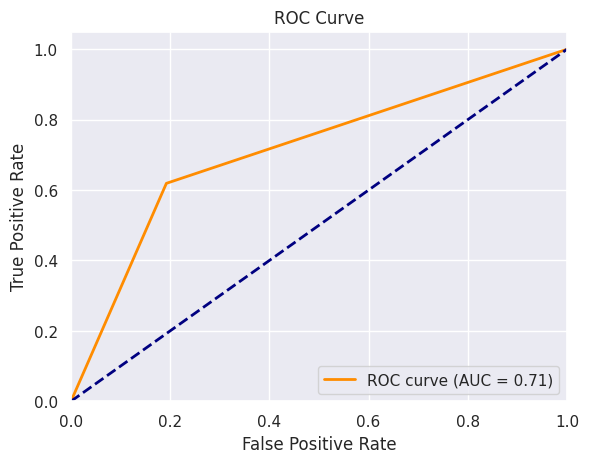

In [75]:
plot_auc(lr_auc_score, lr_fpr, lr_tpr)

In [76]:
lr_train_f1_score = calculate_f1_score(lr_model, X_train_df, y_train)
lr_val_f1_score = calculate_f1_score(lr_model, X_val_df, y_val)

print("F1 score on the training set:", lr_train_f1_score)
print("F1 score on the validation set:", lr_val_f1_score)

F1 score on the training set: 0.6486486486486487
F1 score on the validation set: 0.6265060240963856


In [77]:
cv_scores, avg_f1_score = perform_cross_validation(lr_model, X_train_df, y_train, cv=5, scoring='f1')

print("Cross-Validation Scores:", cv_scores)
print("Average F1 Score:", avg_f1_score)

Cross-Validation Scores: [0.6557377  0.64615385 0.65384615 0.55555556 0.70967742]
Average F1 Score: 0.6441941359656855


### Decision tree

In [78]:
dt_model = DecisionTreeClassifier(random_state=42)
(dt_model, dt_preds, dt_f1_score, dt_fpr, dt_tpr, 
                 dt_thresholds, dt_auc_score) = fit_and_evaluate_model(X_train_df, y_train, X_val_df, y_val, dt_model)

In [79]:
print("F1 Score:", dt_f1_score)
print("AUC Score:", dt_auc_score)

F1 Score: 0.6024096385542169
AUC Score: 0.6950549450549451


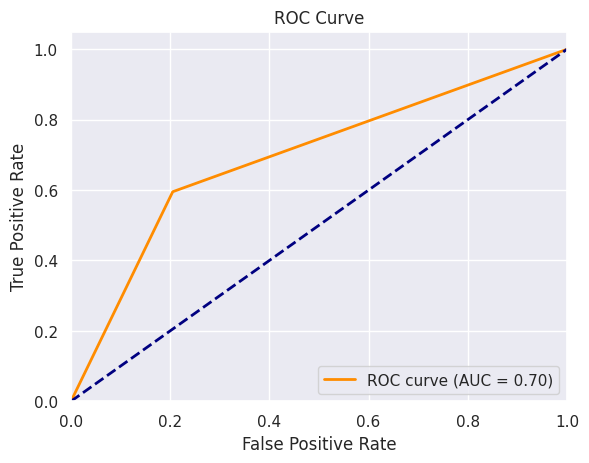

In [80]:
plot_auc(dt_auc_score, dt_fpr, dt_tpr)

In [81]:
dt_train_f1_score = calculate_f1_score(dt_model, X_train_df, y_train)
dt_val_f1_score = calculate_f1_score(dt_model, X_val_df, y_val)

print("F1 score on the training set:", dt_train_f1_score)
print("F1 score on the validation set:", dt_val_f1_score)

F1 score on the training set: 1.0
F1 score on the validation set: 0.6024096385542169


In [82]:
cv_scores, avg_f1_score = perform_cross_validation(dt_model, X_train_df, y_train, cv=5, scoring='f1')

print("Cross-Validation Scores:", cv_scores)
print("Average F1 Score:", avg_f1_score)

Cross-Validation Scores: [0.49180328 0.57142857 0.43636364 0.58461538 0.4516129 ]
Average F1 Score: 0.5071647548643846


### Random Forest Classifier

In [83]:
rf_model = RandomForestClassifier(random_state=42)
(rf_model, rf_preds, rf_f1_score, rf_fpr, rf_tpr, 
                 rf_thresholds, rf_auc_score) = fit_and_evaluate_model(X_train_df, y_train, X_val_df, y_val, rf_model)

In [84]:
print("F1 Score:", rf_f1_score)
print("AUC Score:", rf_auc_score)

F1 Score: 0.5783132530120482
AUC Score: 0.6767399267399268


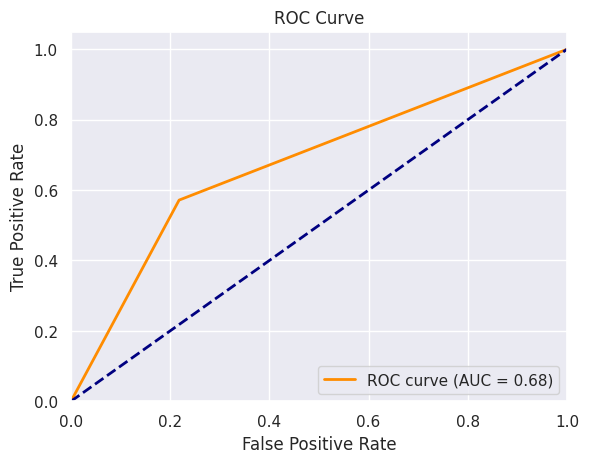

In [85]:
plot_auc(rf_auc_score, rf_fpr, rf_tpr)

In [86]:
rf_train_f1_score = calculate_f1_score(rf_model, X_train_df, y_train)
rf_val_f1_score = calculate_f1_score(rf_model, X_val_df, y_val)

print("F1 score on the training set:", rf_train_f1_score)
print("F1 score on the validation set:", rf_val_f1_score)

F1 score on the training set: 1.0
F1 score on the validation set: 0.5783132530120482


In [87]:
cv_scores, avg_f1_score = perform_cross_validation(rf_model, X_train_df, y_train, cv=5, scoring='f1')

print("Cross-Validation Scores:", cv_scores)
print("Average F1 Score:", avg_f1_score)

Cross-Validation Scores: [0.73846154 0.65671642 0.54901961 0.54545455 0.61290323]
Average F1 Score: 0.6205110670952242


### XGBClassifier

In [88]:
xgb_model = XGBClassifier()
(xgb_model, xgb_preds, xgb_f1_score, xgb_fpr, xgb_tpr, 
                 xgb_thresholds, xgb_auc_score) = fit_and_evaluate_model(X_train_df, y_train, X_val_df, y_val, xgb_model)

In [89]:
print("F1 Score:", xgb_f1_score)
print("AUC Score:", xgb_auc_score)

F1 Score: 0.5882352941176471
AUC Score: 0.6822344322344323


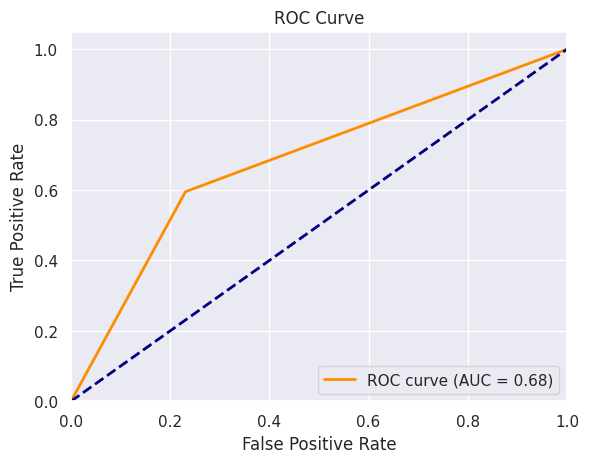

In [90]:
plot_auc(xgb_auc_score, xgb_fpr, xgb_tpr)

In [91]:
xgb_train_f1_score = calculate_f1_score(xgb_model, X_train_df, y_train)
xgb_val_f1_score = calculate_f1_score(xgb_model, X_val_df, y_val)

print("F1 score on the training set:", xgb_train_f1_score)
print("F1 score on the validation set:", xgb_val_f1_score)

F1 score on the training set: 1.0
F1 score on the validation set: 0.5882352941176471


In [92]:
cv_scores, avg_f1_score = perform_cross_validation(xgb_model, X_train_df, y_train, cv=5, scoring='f1')

print("Cross-Validation Scores:", cv_scores)
print("Average F1 Score:", avg_f1_score)

Cross-Validation Scores: [0.65671642 0.67647059 0.5        0.56666667 0.60606061]
Average F1 Score: 0.601182855774603


### SGDClassifier

In [93]:
sgd_model = SGDClassifier()
(sgd_model, sgd_preds, sgd_f1_score, sgd_fpr, sgd_tpr, 
                 sgd_thresholds, sgd_auc_score) = fit_and_evaluate_model(X_train_df, y_train, X_val_df, y_val, sgd_model)

In [94]:
print("F1 Score:", sgd_f1_score)
print("AUC Score:", sgd_auc_score)

F1 Score: 0.6451612903225806
AUC Score: 0.7225274725274726


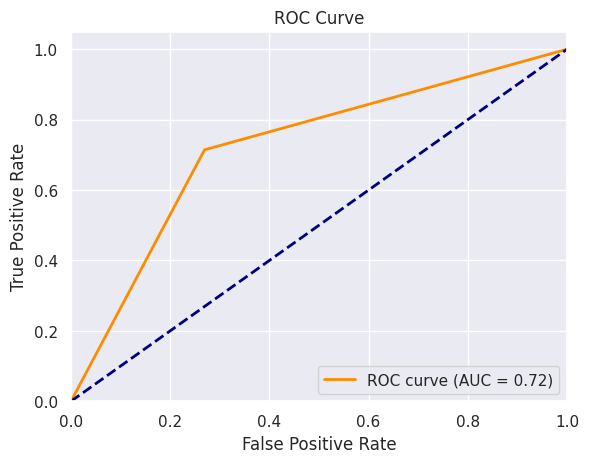

In [95]:
plot_auc(sgd_auc_score, sgd_fpr, sgd_tpr)

In [96]:
sgd_train_f1_score = calculate_f1_score(sgd_model, X_train_df, y_train)
sgd_val_f1_score = calculate_f1_score(sgd_model, X_val_df, y_val)

print("F1 score on the training set:", sgd_train_f1_score)
print("F1 score on the validation set:", sgd_val_f1_score)

F1 score on the training set: 0.6446280991735537
F1 score on the validation set: 0.6451612903225806


In [97]:
cv_scores, avg_f1_score = perform_cross_validation(sgd_model, X_train_df, y_train, cv=5, scoring='f1')

print("Cross-Validation Scores:", cv_scores)
print("Average F1 Score:", avg_f1_score)

Cross-Validation Scores: [0.40677966 0.60869565 0.60377358 0.67532468 0.64935065]
Average F1 Score: 0.5887848445543695


### Usporedba modela

In [98]:
results = {'model':['Decision Tree', 'Random Forest', 'XGBoost', 'Logistic Regression', 'SGDClassifier'],
         'f1_score':[dt_f1_score, rf_f1_score, xgb_f1_score, lr_f1_score, sgd_f1_score],
         'AUC_score':[dt_auc_score, rf_auc_score, xgb_auc_score, lr_auc_score, sgd_auc_score]}

results_df= pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by = 'AUC_score', ascending = False)
results_df_sorted

,model,f1_score,AUC_score
4,SGDClassifier,0.645161,0.722527
3,Logistic Regression,0.626506,0.713370
0,Decision Tree,0.602410,0.695055
2,XGBoost,0.588235,0.682234
1,Random Forest,0.578313,0.676740


### *Oversampling*

In [99]:
oversample= SMOTE()
X_train_resampled, y_train_resampled = oversample.fit_resample(X_train_df, y_train)
X_train_resampled.shape, y_train_resampled.shape

((626, 9), (626,))

In [100]:
# Ponavljanje treniranja modela na novom skupu podataka
lr_model = LogisticRegression()
(lr_model, lr_preds, lr_f1_score_, lr_fpr, lr_tpr, 
                 lr_thresholds, lr_auc_score) = fit_and_evaluate_model(X_train_resampled, y_train_resampled, X_val_df, y_val, lr_model)

dt_model = DecisionTreeClassifier(random_state=42)
(dt_model, dt_preds, dt_f1_score, dt_fpr, dt_tpr, 
                 dt_thresholds, dt_auc_score) = fit_and_evaluate_model(X_train_resampled, y_train_resampled, X_val_df, y_val, dt_model)

rf_model = RandomForestClassifier(random_state=42)
(rf_model, rf_preds, rf_f1_score, rf_fpr, rf_tpr, 
                 rf_thresholds, rf_auc_score) = fit_and_evaluate_model(X_train_resampled, y_train_resampled, X_val_df, y_val, rf_model)

xgb_model = XGBClassifier()
(xgb_model, xgb_preds, xgb_f1_score, xgb_fpr, xgb_tpr, 
                 xgb_thresholds, xgb_auc_score) = fit_and_evaluate_model(X_train_resampled, y_train_resampled, X_val_df, y_val, xgb_model)

sgd_model = SGDClassifier()
(sgd_model, sgd_preds, sgd_f1_score, sgd_fpr, sgd_tpr, 
                 sgd_thresholds, sgd_auc_score) = fit_and_evaluate_model(X_train_df, y_train, X_val_df, y_val, sgd_model)

In [101]:
results = {'model':['Decision Tree', 'Random Forest', 'XGBoost', 'Logistic Regression', 'SGDClassifier'],
         'f1_score':[dt_f1_score, rf_f1_score, xgb_f1_score, lr_f1_score, sgd_f1_score],
         'AUC_score':[dt_auc_score, rf_auc_score, xgb_auc_score, lr_auc_score, sgd_auc_score]}

results_df= pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by = 'AUC_score', ascending = False)
results_df_sorted

,model,f1_score,AUC_score
2,XGBoost,0.659341,0.735348
3,Logistic Regression,0.626506,0.714286
1,Random Forest,0.610526,0.691392
4,SGDClassifier,0.519481,0.641941
0,Decision Tree,0.528736,0.632784


## Evaluacija modela

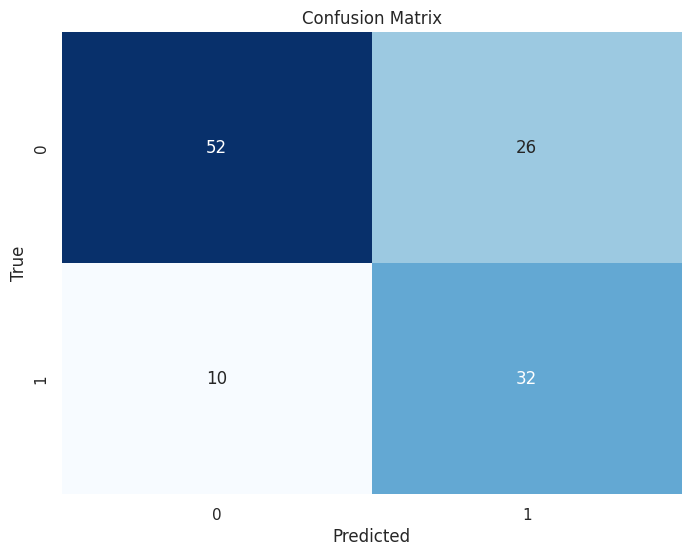

In [102]:
cm = confusion_matrix(y_val, lr_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

**Preciznost (Precision):**

$\text{Precision} = \frac{TP}{TP + FP} = \frac{32}{32 + 23} = \frac{32}{55} \approx 0.58$

**Odziv (Recall):**

$\text{Recall} = \frac{TP}{TP + FN} = \frac{32}{32 + 11} = \frac{32}{43} \approx 0.74$

## Spremanje modela

In [103]:
cwd = os.getcwd()
destination = os.path.join(cwd, 'app/models')
os.makedirs(destination, exist_ok=True)

imputer_filepath = os.path.join(destination, 'numerical_imputer.joblib')
dump(numerical_imputer, imputer_filepath)

scaler_filepath = os.path.join(destination, 'scaler.joblib')
dump(scaler, scaler_filepath)

model_filepath = os.path.join(destination, 'lr_model.joblib')
dump(lr_model, model_filepath)

print(f"Numerical Imputer exported to: {imputer_filepath}")
print(f"Scaler exported to: {scaler_filepath}")
print(f"Logistic Regression Model exported to: {model_filepath}")

Numerical Imputer exported to: /home/dsabljic/ds/folder/Sepsis-Classification/app/models/numerical_imputer.joblib
Scaler exported to: /home/dsabljic/ds/folder/Sepsis-Classification/app/models/scaler.joblib
Logistic Regression Model exported to: /home/dsabljic/ds/folder/Sepsis-Classification/app/models/lr_model.joblib


## Učitavanje i predikcija

In [104]:
lr_model = load("./app/models/lr_model.joblib")
scaler = load("./app/models/scaler.joblib")
imputer = load("./app/models/numerical_imputer.joblib")

In [105]:
feature_names = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance']

data = [[1, 85, 66, 29, 0, 26.6, 0.351, 31, 0]]
data = pd.DataFrame(data, columns=feature_names)
data

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
0,1,85,66,29,0,26.6,0.351,31,0


In [106]:
data_imputed = imputer.transform(data)
data_scaled = scaler.transform(data_imputed)

In [107]:
data_scaled_df = pd.DataFrame(data_scaled, columns=feature_names)

In [108]:
data_scaled_df

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
0,-0.863613,-1.07225,-0.123544,0.531986,-0.722247,-0.700527,-0.407083,-0.206068,-1.473834


In [109]:
prediction = lr_model.predict_proba(data_scaled_df)
positive_proba = prediction[0][1]
    
results = ("Positive", round(positive_proba * 100, 2)) if positive_proba > 0.5 else ("Negative", round((1 - positive_proba) * 100, 2))
    
{"result": results[0], "confidence": results[1]}

{'result': 'Negative', 'confidence': 92.67}